In [1]:
#!/Tsan/bin/python
# -*- coding: utf-8 -*-

In [125]:
# Libraries to use
from __future__ import division 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import mysql.connector 
import json
import collections

In [127]:
import talib as tb

In [4]:
# Import My own library for factor testing
from SingleFactorTest import factorFilterFunctions as ff
#from config import *

In [5]:
%matplotlib inline
%load_ext line_profiler

In [6]:
# {'600036':u'招商银行','002142':u'宁波银行','601939':u'建设银行','000709':u'河钢股份','000807':u'云铝股份','600111':u'北方稀土',
#  '002001':u'新和成','002562':u'兄弟科技','0300121':u'阳谷华泰','600352':u'浙江龙盛','600409':u'三友化工','000636':u'风华高科',
#  '000962':u'东方钽业','300228':u'富瑞特装'，'600681':u'百川能源','600789':u'鲁抗医药','002166':u'莱茵生物','002166':u'万华化学',
# '000933':u'神火股份','600977':u'中国电影','000802':u'北京文化','600809':u'山西汾酒','600438':u'通威股份','000970':u'中科三环'}

In [7]:
# 股票推荐字典
stkdict = {'20170815':['600036','002142','601939'], '20170814':['000709','000807','600111','002001','002562'],\
          '20170810':['300121','600352','600409'], '20170809':['000636','000962'], '20170808':['600803','300228','600681'],
          '20170807':['600789','002166','600309'],'20170803':['000933','600977','000802','600809'],
          '20170801':['600438'], '20170731':['600438','600111','000970']}

In [8]:
sortedstkdict = collections.OrderedDict(sorted(stkdict.items()))

In [9]:
fileNameClose = 'LZ_CN_STKA_QUOTE_TCLOSE.h5.csv'
fileNameOpen = 'LZ_CN_STKA_QUOTE_TOPEN.h5.csv'

In [10]:
path = ff.data_path
# Constants
startTime =  datetime.strptime('20170731', '%Y%m%d')
endTime = datetime.strptime('20170816', '%Y%m%d')

In [11]:
# 开盘价
openPrice= pd.read_csv(path+fileNameOpen,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]

stkList = map(lambda x: x.split('.')[0],openPrice.columns[1:])

openPrice = openPrice.iloc[:,:-1]

openPrice.columns = stkList 

IOError: File D:/cStrategy/Factor/LZ_CN_STKA_QUOTE_TOPEN.h5.csv does not exist

In [ ]:
# 收盘价
closePrice= pd.read_csv(path+fileNameClose,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]

stkList = map(lambda x: x.split('.')[0],closePrice.columns[1:])

closePrice = closePrice.iloc[:,:-1]

closePrice.columns = stkList

In [ ]:
closePrice

In [ ]:
InitiCap = 100000  # 初始资金
capital = InitiCap  
feeRate = 0.0003  # 手续费+冲击成本
stampTaxRate = 0.001  # 印花税
buyList = []
availableCash = {}  # 每天的现金流量
# 生成购买的股票池
for key,item in sortedstkdict.iteritems():
    print key
    date = datetime.strptime(key, '%Y%m%d')
    totalCostToday = 0  # 当天买入的所有股票的成本
    for stk in item:        
        buyPrice = round(openPrice.loc[date][stk],2)
        amount = 100
        cost = round(buyPrice*amount*(1+feeRate),2)
        buyList.append([date,stk,buyPrice,amount,cost,1]) # 日期，股票代码，购买价格，购买数量，总cost,方向
        totalCostToday+= cost
    assert capital > totalCostToday
    capital  = capital  - totalCostToday
    availableCash[date] = capital  # 买入股票后剩下的资金

In [ ]:
availableCash

In [ ]:
dateList = sorted([datetime.strptime(key, '%Y%m%d') for key in stkdict.keys()])

dateList = closePrice.loc[dateList[0]:dateList[-1]].index

dateList

In [ ]:
availableCash

In [ ]:
availableCashSeries = pd.Series(index = dateList,data = availableCash )

availableCashSeries = availableCashSeries.ffill()

availableCashSeries

In [ ]:
availableCashSeries

In [ ]:
buyList

In [ ]:
# 简单回测
cutwinthreshold = 0.05
cutlossthreshold  = -0.05
pnldict = {}
sellList = []
for tradeitem in buyList:
    pnl = (closePrice.loc[tradeitem[0]:][tradeitem[1]] - tradeitem[2]) / tradeitem[2]  # 计算每天的pnl
    cutwin = pnl[pnl >= cutwinthreshold]
    cutloss = pnl[pnl <= cutlossthreshold]
    if len(cutwin) > 0:    # 如果达到止盈线，则按当天收盘价止盈
        pnldict[tradeitem[1]] = round(cutwin .iloc[0],2)
        selldate = cutwin.index[0]
        sellPrice = closePrice.loc[selldate][tradeitem[1]]
        cost = round(sellPrice*tradeitem[3]*(1-stampTaxRate),2)
        sellList.append([selldate,tradeitem[1],round(sellPrice,2),tradeitem[3],cost,-1]) # 卖出list的格式与买入相同
        availableCashSeries.loc[selldate:]+= cost   # 记录到资金账户里
    elif  len(cutloss) > 0:     #  反之则止损
        pnldict[tradeitem[1]] = round(cutloss .iloc[0],2)
        selldate = cutloss.index[0]
        sellPrice = closePrice.loc[selldate][tradeitem[1]]
        cost = round(sellPrice*tradeitem[3]*(1-stampTaxRate),2)
        sellList.append([selldate,tradeitem[1],round(sellPrice,2),tradeitem[3],cost,-1]) # 卖出list的格式与买入相同
        availableCashSeries.loc[selldate:]+= cost 
    else:                                   # 没有达到止盈止损线的情况下，按照倒数第二天的收盘价计算pnl
        pnldict[tradeitem[1]] = round(pnl.iloc[-2],2)

In [ ]:
sellList

In [ ]:
holdingList = list(set([i[1] for i in buyList]) - set([i[1] for i in sellList]))

In [ ]:
holdingList

In [ ]:
selldatepair = {i[1]:i[0] for i in buyList if i[1] in holdingList}
selldatepair

In [ ]:
tempo = closePrice[holdingList]

In [ ]:
position = tempo.copy()
for stk,date in selldatepair.iteritems():
    filterCondition = tempo[tempo[stk].index >= date]
    falseCondition= tempo[tempo[stk].index  < date]
    position.loc[filterCondition.index,stk]= 100
    position.loc[falseCondition.index,stk]=  0
position

In [ ]:
marketValue = position*tempo

In [ ]:
marketValue.sum(axis=1)+availableCashSeries

In [ ]:
# 计算卖出时得到的资金
for sellitem in sellList:
    availableCashSeries.loc[sellitem[0]]+= sellitem[-2]
availableCashSeries

In [ ]:
# 合并买卖订单
tradingList = buyList + sellList
tradingCode = list(set([i[1] for i in buyList]) | set([i[1] for i in sellList]))

In [ ]:
tradingList

In [ ]:
# 创建tradingsheet
tradingSheet = pd.DataFrame(index = dateList, columns = tradingCode, data=0, dtype = float)

for item in tradingList:
    tradingSheet .loc[item[0],item[1]]+= item[-1] * item[-3]
positionchangeDF = tradingSheet .cumsum().ffill()

In [ ]:
tradingSheet 

In [ ]:
positionchangeDF

In [ ]:
# 总资产
totalCapital= (positionchangeDF * closePrice[positionchangeDF.columns]).sum(axis=1)+ availableCashSeries

In [ ]:
totalCapital

In [ ]:
# 年化收益率
annualizedRet = ((totalCapital.iloc[-2] - InitiCap)/ InitiCap +1)**(250/(len(totalCapital)-1)) -1

In [ ]:
annualizedRet 

In [ ]:
availableCashSeries

In [ ]:
pnlseries = pd.Series(pnldict)

In [ ]:
pnlseries.describe()

In [ ]:
plt.hist(pnlseries)

In [ ]:
#-----------------------------------------------------Market Timing------------------------------------

In [ ]:
filenameHS300Member = 'LZ_CN_STKA_INDEX_HS300MEMBER.h5'
filenameCSI500Member = 'LZ_CN_STKA_INDEX_CSI500MEMBER.h5'

# 复权后价格
filenameAdjClose = 'OwnfactorAdjustedClose.h5'

In [ ]:
teststartTime =  datetime.strptime('20120731', '%Y%m%d')
testendTime = datetime.strptime('20171016', '%Y%m%d')

In [ ]:
def getMemberList(path,filename):
    df = ff.readh5data(path,filename).iloc[-1]
    return df.loc[df==1].index.tolist()

In [ ]:
hs300MemberList = getMemberList(path, filenameHS300Member)
csi500MemberList = getMemberList(path, filenameCSI500Member)

In [ ]:
priceData =  ff.readh5data(path,filenameAdjClose).pct_change().dropna(how='all').loc[teststartTime:testendTime]

In [ ]:
priceData[hs300MemberList].loc[datetime.strptime('20170810', '%Y%m%d')].name

In [ ]:
priceData[hs300MemberList].loc[datetime.strptime('20170810', '%Y%m%d')].hist()

In [ ]:
priceData[csi500MemberList].iloc[-2].name

In [ ]:
#-----------------------------------------------------CTA Backtest Engine------------------------------------

In [ ]:
def getNewMatrix(inputArray, t, m):
    newMatrix = []
    n = t-m+1
    for i in range(n):
        newdata = list(inputArray[i:m+i])
        newMatrix.append(newdata)
    #newMatrix = np.array(newMatrix).reshape(n,m)
    return np.array(newMatrix)

def recreateArray(newMatrix,t,m):
    ret = []
    n = t - m + 1
    for p in range(1, t+1):
        if p < m:
            alpha = p
        elif p > t-m+1:
            alpha = t-p+1
        else:
            alpha = m
        sigma = 0
        for j in range(1, m+1):
            i = p - j + 1
            if i > 0 and i < n+1:
                sigma += newMatrix[i-1][j-1]
        ret.append(sigma/alpha)
    return np.array(ret)

def getSVD(inputArray,t,m):
    #print 1
    inputmatrix = getNewMatrix(inputArray, t, m)
    u, s, v = np.linalg.svd(inputmatrix)
    eviNum = 1 if s[0]/s.sum() > 0.99 else 2
    sNew = np.zeros((eviNum, eviNum))
    np.fill_diagonal(sNew, s[:eviNum])
    matrixForts = np.dot(np.dot(u[:, :eviNum].reshape(u.shape[0], eviNum), sNew), v[:eviNum])
    #print matrixForts.shape
    newts = recreateArray(matrixForts, t, m)
    return newts

In [12]:
old_path = 'C:/Users/LZJF_02/Desktop/original_data/'
new_path = 'C:/Users/LZJF_02/Desktop/modified_data/'
filename = 'rb000_1min.csv'
#newname = 'j9000_1min_modi.csv'

In [13]:
startTime =  datetime.strptime('20160110', '%Y%m%d') # 上涨趋势
endTime = datetime.strptime('20161107', '%Y%m%d')

startTrainTime = datetime.strptime('20150530', '%Y%m%d') 
endTimeTrain =  datetime.strptime('20160530', '%Y%m%d')

startTimeVal = datetime.strptime('20151016', '%Y%m%d')  # 下跌趋势
endTimeVal = datetime.strptime('20151123', '%Y%m%d')

startTimeSurge =  datetime.strptime('20170606', '%Y%m%d') # 上涨趋势
endTimeSurge = datetime.strptime('20170809', '%Y%m%d')

startTimePlunge =  datetime.strptime('20170906', '%Y%m%d') # 下跌趋势
endTimePlunge = datetime.strptime('20170929', '%Y%m%d')

In [14]:
# svd滤波参数
shapeNum = 30
svdShort = 7
svdLong = 20

In [15]:
# 期货合约相关参数
Leverage = 10
Slipage = 2
ContractSize = 10
IniCapital = 100000
FeeRate = 0.003
PriceTick = 1

In [16]:
data = pd.read_csv(old_path+filename,infer_datetime_format=True,header=None,names = ['Open', 'High', 'Low', 'Close','TotalVolume','OpenInterest'])
data.index = data.index.map(lambda x : pd.to_datetime(x))

In [17]:
data['OpenRatio'] = (data['OpenInterest'] - data['OpenInterest'].shift(1)) / data['TotalVolume']

In [18]:
data.loc[startTime:].describe()
data.loc[startTime:].quantile(0.85)

Open            3.454000e+03
High            3.457000e+03
Low             3.452000e+03
Close           3.454000e+03
TotalVolume     3.324800e+04
OpenInterest    4.524026e+06
OpenRatio       1.723304e-01
Name: 0.85, dtype: float64

In [19]:
data.tail(20)

,Open,High,Low,Close,TotalVolume,OpenInterest,OpenRatio
2017-09-18 11:16:00,3786,3789,3770,3776,56594,4057618,0.105559
2017-09-18 11:17:00,3775,3779,3771,3771,25718,4061640,0.156389
2017-09-18 11:18:00,3771,3780,3771,3776,15230,4065086,0.226264
2017-09-18 11:19:00,3776,3777,3772,3773,9056,4066862,0.196113
2017-09-18 11:20:00,3773,3773,3764,3766,38662,4072204,0.138172
2017-09-18 11:21:00,3767,3770,3766,3768,15876,4075438,0.203704
2017-09-18 11:22:00,3767,3768,3764,3764,18014,4077740,0.127789
2017-09-18 11:23:00,3763,3765,3759,3763,32302,4083090,0.165624
2017-09-18 11:24:00,3762,3768,3760,3768,15844,4085922,0.178743
2017-09-18 11:25:00,3769,3769,3762,3762,12436,4087190,0.101962


In [20]:
data.describe()

,Open,High,Low,Close,TotalVolume,OpenInterest,OpenRatio
count,576590.000000,576590.000000,576590.000000,576590.000000,576590.000000,5.765900e+05,576589.000000
mean,3279.472292,3280.876907,3278.048208,3279.472297,11638.035467,2.440778e+06,-0.003634
std,949.560688,949.722005,949.397871,949.559562,15181.314867,1.293012e+06,0.224045
min,1617.000000,1618.000000,1616.000000,1617.000000,2.000000,8.376000e+03,-1.638679
25%,2422.000000,2423.000000,2421.000000,2422.000000,2578.000000,1.345436e+06,-0.130831
50%,3409.000000,3410.000000,3407.000000,3409.000000,6876.000000,2.478721e+06,0.004251
75%,4074.000000,4076.000000,4072.000000,4074.000000,14788.000000,3.501908e+06,0.133173
max,5186.000000,5187.000000,5182.000000,5185.000000,583962.000000,6.040226e+06,1.000000


In [21]:
d = {'x': {'b': 10, 'c': 20}, 'y': {'b': '33', 'c': 44,'a':1}}

In [22]:
data['TotalVolume'].idxmax()

Timestamp('2016-03-08 10:05:00')

In [23]:
dd=[1,2,3,4.5,-2.3]
s =pd.Series(dd)
s[s<0].shape

(1L,)

In [24]:
#pd.DataFrame.from_dict(f,orient='index')

NameError: name 'f' is not defined

In [176]:
c = u'1,231'.encode('utf-8').split(',')
float(c[0] +c[1])

1231.0

In [179]:
float("123,456.908".replace(',',''))

123456.908

In [25]:
dataIndice = data.loc[startTime:endTime]
indexby5MIN = filter(lambda x : x.minute % 5 ==0, dataIndice.index)

# modify data by customized method
#dataIndice = data.loc[startTime:]
resultList = []
for index, time in enumerate(indexby5MIN):
    if index < len(indexby5MIN) - 1:
        tempdata = dataIndice.loc[time:indexby5MIN [index+1]].iloc[:-1]
        resultdict = {}
        resultdict['Open'] = tempdata['Open'].values[0]
        resultdict['High'] = tempdata['High'].max()
        resultdict['Low'] = tempdata['Low'].min()
        resultdict['Close'] = tempdata['Close'].values[-1]
        resultdict['TotalVolume'] = tempdata['TotalVolume'].sum()
        resultdict['OpenInterest'] = tempdata['OpenInterest'].values[-1]
        resultdict['OpenRatio'] = tempdata['OpenRatio'].values[-1]
        resultdict['OpenRatioModi'] = (np.sqrt(tempdata['TotalVolume']) * tempdata['OpenRatio'] / \
                                       (np.sqrt(tempdata['TotalVolume']).sum())).mean()
        resultdict['time'] = time
        resultList.append(resultdict)
df = pd.DataFrame(resultList,columns = ['Open','High','Low','Close','TotalVolume','OpenInterest','OpenRatio','time','OpenRatioModi'])  

dataClean = df.set_index('time')
dataClean['pnl'] = dataClean['Close'].pct_change()
dataClean['nextpnl'] = dataClean['pnl'].shift(1)

In [133]:
np_real_data = np.array(dataClean['Close'].values,dtype='f8')

In [140]:
alpha1 = (np.cos(0.707 * np.pi /48) + np.sin(0.707 * np.pi /48) - 1 ) / np.cos(0.707 * np.pi /48)
alpha1

0.045234543450991919

In [146]:
LPPeriod = 20
a1 = np.exp(-1.414 * np.pi / LPPeriod) 
b1 = 2 * a1 * np.cos(1.414 * np.pi /  LPPeriod) 
c2 = b1
c3 = - a1 * a1
c1 = 1 - c2 - c3 

In [ ]:
HP = np.zeros(close)
HP = (1 - alpha1 / 2) ** 2 * (Close - 2 * Close[-1] + Close[-2]) + 2 * (1 - alpha1) * HP[-1] - (1 - alpha1) ** 2 * HP[-2]

In [154]:
# Stay long if price is trading above HT_TRENDLINE and stay short if price is trading below HT_TRENDLINE.
tb.HT_TRENDLINE(np_real_data[-200:])[np.isnan(tb.HT_TRENDLINE(np_real_data[-500:]))].__len__()

c:\python27\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 200 but corresponding boolean dimension is 500
  from ipykernel import kernelapp as app


63

In [136]:
np_real_data / tb.HT_TRENDLINE(np_real_data)

array([        nan,         nan,         nan, ...,  1.00360515,
        1.00545756,  1.00777331])

In [165]:
n

True

In [43]:
dataClean.Close.values

array([1759, 1758, 1755, ..., 2731, 2737, 2745], dtype=int64)

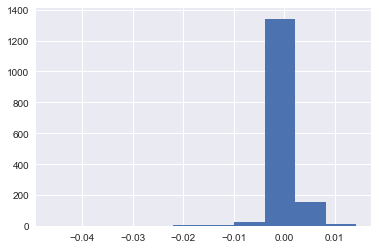

In [27]:
dataClean[dataClean['OpenRatioModi'] > 0.023]['nextpnl'].hist()

In [28]:
dataClean['pnl'].mean()

3.199237800532039e-05

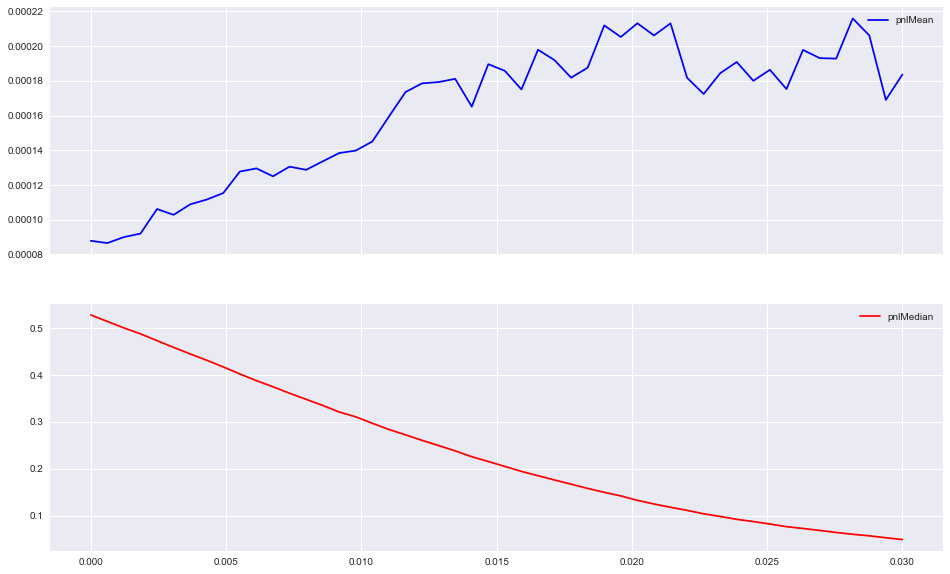

In [29]:
# check the monotonity of pnl filtered by openRatio indicator in bullish market
variation = []
bullpnlMeanList = []
bullpnlMedianList = []
x_axis = np.linspace(0,0.03,50)
for i in x_axis:
    variation.append(i)
    bullpnlMeanList.append(dataClean[dataClean['OpenRatioModi'] >= i]['pnl'].mean())
    bullpnlMedianList.append(dataClean[dataClean['OpenRatioModi'] >= i]['pnl'].shape[0] / dataClean.shape[0])
fig, (ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(16,10))
ax1.plot(x_axis,bullpnlMeanList,'blue',label='pnlMean')
ax2.plot(x_axis,bullpnlMedianList,'red',label='pnlMedian')
ax1.legend()
ax2.legend()

新指标做多阈值大概为0.02(0.85左右的分位数)，做空为0.024(0.8的分位数),也可取（0.85的分位数0.0275）

In [30]:
np.sqrt(np.array([1,2,3,4]))/np.sqrt(np.array([1,2,3,4])).sum()

array([ 0.16270045,  0.23009319,  0.28180545,  0.32540091])

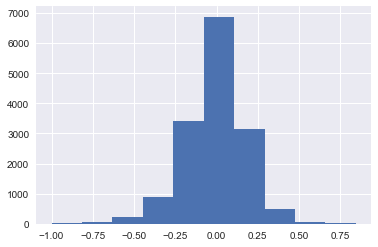

In [31]:
dataClean['OpenRatio'].hist()

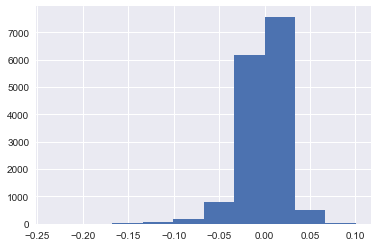

In [32]:
dataClean['OpenRatioModi'].hist()

In [33]:
a,b,c = 10000,3000,7000
print np.sqrt(a) / (np.sqrt(a)+np.sqrt(b)+np.sqrt(c))
print np.sqrt(b) / (np.sqrt(a)+np.sqrt(b)+np.sqrt(c))
print np.sqrt(c) / (np.sqrt(a)+np.sqrt(b)+np.sqrt(c))

0.419395782663
0.229712530687
0.350891686651


In [34]:
print 3/(1+2+3)
print 1/(1+2+3)
print 2/(1+2+3)

0.5
0.166666666667
0.333333333333


In [35]:
print np.log10(a) / (np.log10(a)+np.log10(b)+np.log10(c))
print np.log10(b) / (np.log10(a)+np.log10(b)+np.log10(c))
print np.log10(c) / (np.log10(a)+np.log10(b)+np.log10(c))

0.353287628147
0.307105980215
0.339606391638


In [36]:
print np.log(a) / (np.log(a)+np.log(b)+np.log(c))
print np.log(b) / (np.log(a)+np.log(b)+np.log(c))
print np.log(c) / (np.log(a)+np.log(b)+np.log(c))

0.353287628147
0.307105980215
0.339606391638


In [37]:
#c = data.loc[startTime:].groupby(pd.TimeGrouper(freq='5Min'))

In [38]:
#nlarge = c['TotalVolume'].nlargest()

In [39]:
#nlarge.iloc[:50]

In [40]:
# Rescale openratio by the rank of Volume corresponding trading minute. e.g.Weighing the Open ratio by the order of total volume.
a = c['TotalVolume'].rank()/15 * data['OpenRatio']  
dataslice = data.loc[a.index]
dataslice['ModiOR'] = a
dataslice.groupby(pd.TimeGrouper(freq='5Min'))['OpenRatio'].mean().dropna().describe()

TypeError: 'int' object has no attribute '__getitem__'

In [ ]:
dataslice.groupby(pd.TimeGrouper(freq='5Min'))['OpenRatio'].mean().dropna().hist()

In [ ]:
dataModi = dataslice.groupby(pd.TimeGrouper(freq='5Min'))['OpenRatio'].mean().dropna()
dataModi.quantile(0.85)

In [ ]:
def resample_data(data,period='5Min'):
    # 将一分钟线聚合为5分钟线
    databy5min = pd.DataFrame()
    groupgenerator = data.groupby(pd.TimeGrouper(freq=period))
    databy5min['Open'] = groupgenerator['Open'].first()
    databy5min['High'] = groupgenerator['High'].max()
    databy5min['Low'] = groupgenerator['Low'].min()
    databy5min['Close'] = groupgenerator['Close'].last()
    databy5min['TotalVolume'] = groupgenerator['TotalVolume'].sum()
    databy5min['OpenInterest'] = groupgenerator['OpenInterest'].last()
    databy5min.dropna(axis=0,inplace = True)
    return databy5min

In [ ]:
dfResampled = resample_data(data)

In [ ]:
dfResampled['OpenRatio'] = (dfResampled['OpenInterest'] - dfResampled['OpenInterest'].shift(1)) / dfResampled['TotalVolume']
dfResampled['WeightedOpenRatio'] = (dfResampled['OpenInterest'] - dfResampled['OpenInterest'].shift(1)) / np.sqrt(dfResampled['TotalVolume'])
dfResampled['pnl'] = dfResampled['Close'].pct_change()

In [ ]:
sampleSurge= dfResampled.loc[startTimeSurge:endTimeSurge]
sampleSurge['nextpnl'] = sampleSurge['pnl'].shift(-1)

In [ ]:
sampleSurge

In [ ]:
samplePlunge = dfResampled.loc[startTimePlunge:endTimePlunge]
samplePlunge['nextpnl'] = samplePlunge['pnl'].shift(-1)

In [ ]:
samplePlunge['OpenRatio'].hist()

In [ ]:
sampleSurge['nextpnl'].describe()

In [ ]:
sampleSurge['OpenRatio'].hist()

In [ ]:
sampleSurge[sampleSurge['OpenRatio'] > .15]['nextpnl'].hist()

In [ ]:
sampleSurge[sampleSurge['OpenRatio'] > 0.03]['nextpnl'].describe()

In [ ]:
# check the monotonity of pnl filtered by openRatio indicator in bullish market
variation = []
bullpnlMeanList = []
bullpnlMedianList = []
for i in np.linspace(0,0.2,40):
    variation.append(i)
    bullpnlMeanList.append(sampleSurge[sampleSurge['OpenRatio'] >= i]['pnl'].mean())
    bullpnlMedianList.append(sampleSurge[sampleSurge['OpenRatio'] >= i].shape[0] / sampleSurge.shape[0])
fig, (ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(16,10))
ax1.plot(np.linspace(0,0.2,40),bullpnlMeanList,'blue',label='pnlMean')
ax2.plot(np.linspace(0,0.2,40),bullpnlMedianList,'red',label='pnlMedian')
ax1.legend()
ax2.legend()

In [ ]:
# check the monotonity of pnl filtered by openRatio indicator in bearrih market
variation = []
bearpnlMeanList = []
bearpnlMedianList = []
for i in np.linspace(0,0.2,40):
    variation.append(i)
    bearpnlMeanList.append(samplePlunge[samplePlunge['OpenRatio'] >= i]['nextpnl'].mean())
    bearpnlMedianList.append(samplePlunge[samplePlunge['OpenRatio'] >= i].shape[0] / samplePlunge.shape[0])
fig, (ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(16,10))
ax1.plot(np.linspace(0,0.2,40),bearpnlMeanList,'blue',label='pnlMean')
ax2.plot(np.linspace(0,0.2,40),bearpnlMedianList,'red',label='pnlMedian')
ax1.legend()
ax2.legend()

In [ ]:
sampleSurge[sampleSurge['OpenRatio'] >= 0.1]['nextpnl'].hist()

In [ ]:
pnlMedianList

In [ ]:
dfResampled['OpenRatio'].loc[startTime:].hist()

In [ ]:
dfResampled['WeightedOpenRatio'].quantile(0.996)

In [ ]:
dfResampled[dfResampled['OpenRatio'] > 0].mean()

In [ ]:
dfResampled['OpenRatio'].tail(500).plot()

In [ ]:
dfResampled['Close'].tail(30).plot()

In [ ]:
dfResampled[['pnl','OpenRatio']].tail(50)

In [ ]:
len(dfResampled[dfResampled['OpenRatio'] < 0.15]) / len(dfResampled)

In [ ]:
len(dfResampled[dfResampled['OpenRatio'] < 0]) / len(dfResampled)

In [ ]:
np.sqrt(0.33*225/5)

In [ ]:
datatrain = dfResampled.loc[startTrainTime:endTimeTrain]

In [ ]:
startTime

In [ ]:
datatrain['EMAOpenRatio'] = talib.EMA(datatrain['OpenRatio'].values, timeperiod=4)

datatrain['EMAOpenRatio'].describe()

In [ ]:
datatrain['OpenRatio'].describe()

In [ ]:
datatrain['EMAOpenRatio'].quantile(0.92)

In [ ]:
datatrain['OpenRatio'].quantile(0.9)

In [ ]:
# show size distribution(quantile plot)
fig = plt.figure(figsize=(16,10))
# Add a subplot
ax = fig.add_subplot(111)
datatrain['EMAOpenRatio'].hist(alpha =0.8)
datatrain['OpenRatio'].hist(alpha = 0.3)
ax.set_title(ax.get_title(),alpha=0.7, fontsize=25)

In [ ]:
datatrain['EMAOpenRatio'].hist()
datatrain['OpenRatio'].hist(alpha = 0.3)

In [ ]:
datatrain['OpenRatio'].describe()

In [ ]:
dfResampled['Close'].plot(figsize=(18,12))

In [ ]:
shapeNum = 20

In [ ]:
svdindicator = getSVD(datatrain['Close'].values[-shapeNum:], shapeNum, svdShort)

In [ ]:
svdindicator1 = getSVD(datatrain['Close'].values[-shapeNum:], shapeNum, svdLong)
svdindicator1

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True,figsize=(16,10))
ax1.plot(datatrain.index[-shapeNum:],datatrain['Close'].values[-shapeNum:],'blue',label='Close')
ax2.plot(datatrain.index[-shapeNum:],svdindicator,'green',)
ax2.plot(datatrain.index[-shapeNum:],svdindicator1,'black')
#ax1.title('SVD')

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True,figsize=(22,16))
ax1.plot(datatrain['Close'].values[-shapeNum:],'blue',label='Close')
ax2.plot(svdindicator,'red',label='svd-'+str(svdShort))
ax2.plot(svdindicator1,'yellow',label='svd-'+str(svdLong))
#ax1.title('SVD')
ax1.legend()
ax2.legend()

In [ ]:
datatrain['Close'].plot(figsize=(18,12))

In [ ]:
#kvol.median()

In [ ]:
kvol = (datatrain['Close'] - datatrain['Close'].shift(1)).rolling(min_periods=60,window=60,center=False).std()

In [ ]:
kvol.iloc[-100:].plot(figsize=(18,12))
((7*datatrain['Close']/datatrain['Close'].iloc[0]).iloc[-100:]).plot(sharex=True)

In [ ]:
datatrain['Close'].iloc[-500:].plot(figsize=(18,12))

In [ ]:
datatrain['Impact'] = (datatrain['Close'] - datatrain['Open']) / datatrain['TotalVolume']   

In [ ]:
datatrain['Impact'].iloc[-55:].plot(figsize=(18,12))

In [ ]:
datatrain['TotalVolume'].iloc[-55:].mean()

In [ ]:
datatrain[datatrain['Impact']>0]

In [ ]:
filtered = datatrain[(datatrain['TotalVolume']<datatrain['TotalVolume'].quantile(0.2)) & (datatrain['Impact']>((datatrain[datatrain['Impact']>0]['Impact']).quantile(0.7)))]

In [ ]:
filtered

In [ ]:
datatrain.iloc[:2]

In [ ]:
filtered['Close'].plot(figsize=(18,10))

In [ ]:
trackBackPeriod = 50
code = 'rb000' 
initialNum = 100

In [ ]:
futurebuyList = []
for i in range(initialNum,len(datatrain)-1):
    svdshortArray = getSVD(datatrain['Close'].values[i+1-trackBackPeriod:i+1], trackBackPeriod, svdShort)
    svdlongArray = getSVD(datatrain['Close'].values[i+1-trackBackPeriod:i+1], trackBackPeriod, svdLong)
    if svdshortArray[-2] < svdlongArray[-2] and svdshortArray[-1] > svdlongArray[-1]:
        dfslice = datatrain.iloc[i+1]
        amount = 1
        price = dfslice['Open']
        cost = price * amount
        direction = 1
        futurebuyList.append([dfslice.name,code,price,amount,cost,direction])

In [ ]:
futurebuyList

In [105]:
filefullname = 'C:/Users/LZJF_02/Desktop/temp.xlsx'

In [106]:
xls = pd.ExcelFile(filefullname)
df1 = xls.parse('file',header=0,index_col=0,parse_dates=True)

In [116]:
df = df1.dropna(how='all',axis=1)
df=df.dropna(axis=0)
df.columns = ['open','high','low',u'贵州茅台','amount','volume','hs300',u'白酒指数']
df = df[[u'贵州茅台',u'白酒指数']]
df=df.dropna(axis=0)
df.index.name  = 'time'

In [117]:
df

,贵州茅台,白酒指数
time,,
2004-12-31 00:00:00,8.38,1000.00
2005-01-04 00:00:00,8.34,983.44
2005-01-05 00:00:00,8.52,998.04
2005-01-06 00:00:00,8.37,989.37
2005-01-07 00:00:00,8.44,997.57
2005-01-10 00:00:00,8.75,1014.30
2005-01-11 00:00:00,8.76,1017.21
2005-01-12 00:00:00,8.78,1017.29
2005-01-13 00:00:00,8.83,1015.72


In [118]:
df.index = pd.to_datetime(df.index)

In [119]:
df.index

DatetimeIndex(['2004-12-31', '2005-01-04', '2005-01-05', '2005-01-06',
               '2005-01-07', '2005-01-10', '2005-01-11', '2005-01-12',
               '2005-01-13', '2005-01-14',
               ...
               '2017-11-22', '2017-11-23', '2017-11-24', '2017-11-27',
               '2017-11-28', '2017-11-29', '2017-11-30', '2017-12-01',
               '2017-12-04', '2017-12-05'],
              dtype='datetime64[ns]', name=u'time', length=3142, freq=None)

In [120]:
endOfWeekList = sorted(list(set(df.iloc[df.resample('W').size().cumsum().sub(1)].index)))

In [121]:
vol = df.loc[endOfWeekList].pct_change().rolling(window= 20, min_periods=20).std().round(3)

In [122]:
vol

,贵州茅台,白酒指数
time,,
2004-12-31,NaN,NaN
2005-01-07,NaN,NaN
2005-01-14,NaN,NaN
2005-01-21,NaN,NaN
2005-01-28,NaN,NaN
2005-02-04,NaN,NaN
2005-02-18,NaN,NaN
2005-02-25,NaN,NaN
2005-03-04,NaN,NaN


In [123]:
# make sure that matplotib and seaborn can show Chinese
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

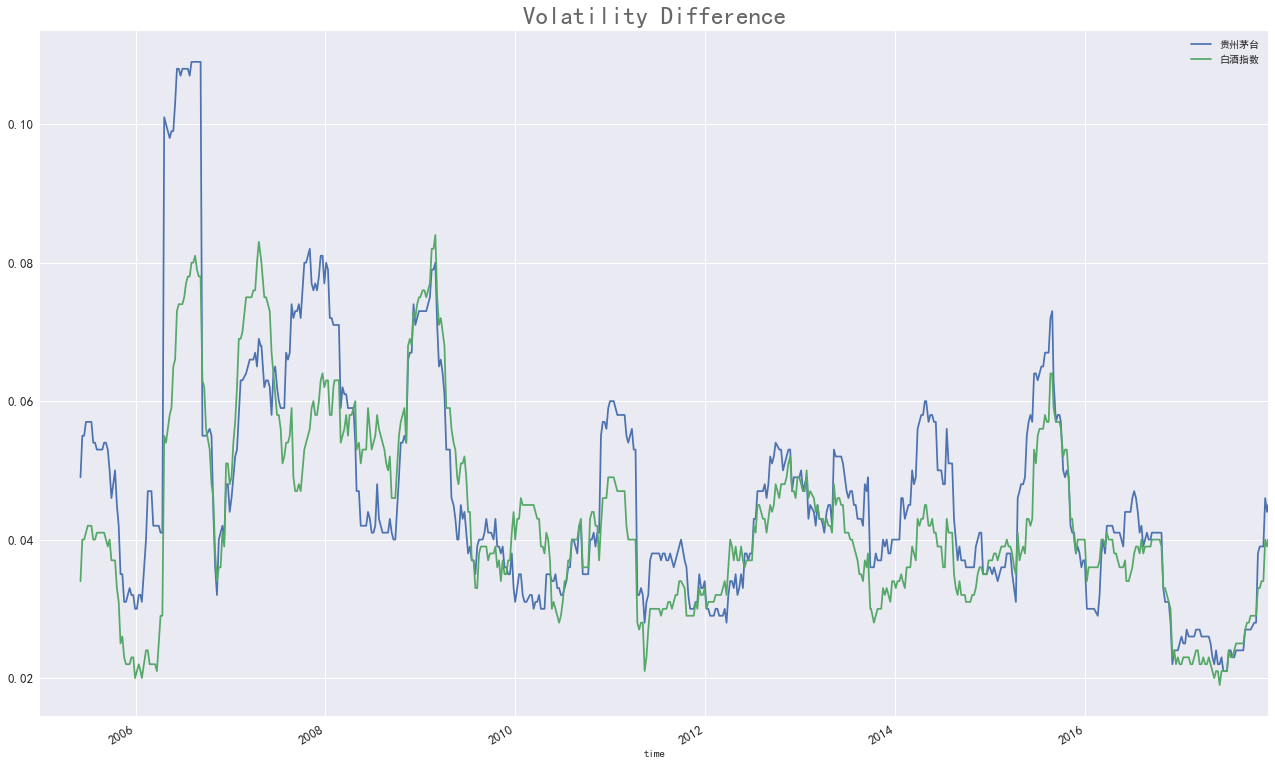

In [124]:
# show size distribution(quantile plot)
fig = plt.figure(figsize=(16,10))
# Add a subplot
ax = fig.add_subplot(111)
vol.plot(figsize=(22,14),ax=ax,title ='Volatility Difference',fontsize =13)
ax.set_title(ax.get_title(),alpha=0.7, fontsize=25)